In [110]:
import numpy as np

In [125]:
def update_motion(current_noise, motion_signs):
    t = 1.0  # truncation
    m = 0.5 #self.motion_react

    update = lambda cn, ms: 1 if cn - m < -2 * t else \
                           -1 if cn + m >= 2 * t else ms
    update_vec = np.vectorize(update)

    return update_vec(current_noise, motion_signs)

In [137]:
def update_motion_2(current_noise, motion_signs):
    t = 1.0  # truncation
    m = 0.5 #self.motion_react
    #new_noise = current_noise.copy()
    current_noise[current_noise - m < -2] = 1
    current_noise[current_noise + m >= 2] = -1
    return new_noise

In [134]:
t = 1.0  # truncation
m = 0.5 #self.motion_react

update = lambda cn, ms: 1 if cn - m < -2 * t else \
                       -1 if cn + m >= 2 * t else ms
update_vec = np.vectorize(update)

In [123]:
update = lambda a: 0.5 if a > 0.5 else a
updater = np.vectorize(update)

In [116]:
noise = np.array([np.random.random() for _ in range(512)])
motion_signs = np.array([np.random.choice([-1, 1]) for _ in range(512)])

In [129]:
%timeit update_motion(noise, motion_signs)

110 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [139]:
%timeit update_motion_2(noise, motion_signs)

5.33 µs ± 12.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [135]:
%timeit update_vec(noise, motion_signs)

110 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
new_noise 

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wav, sr = librosa.load("songs_with_lyrics/Space Oddity.mp3", offset=0, duration=None)
fps = 43

/home/anton/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [3]:
frame_duration = int(sr / fps - (sr / fps % 64))
frame_duration

512

In [4]:
# Generate Mel Spectrogram
spec_raw= librosa.feature.melspectrogram(y=wav, sr=sr,
                                       n_mels=512,
                                       hop_length=frame_duration)

# Obtain maximum value per time-frame
spec_max = np.amax(spec_raw, axis=0)

# Normalize all values between 0 and 1
spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)


In [5]:
spec_raw.shape

(512, 14232)

In [67]:
ax = 0
spec_minmax = (spec_raw - spec_raw.min(axis=ax, keepdims=True)) / (spec_raw.max(axis=ax, keepdims=True) - spec_raw.min(axis=ax, keepdims=True))

<AxesSubplot:>

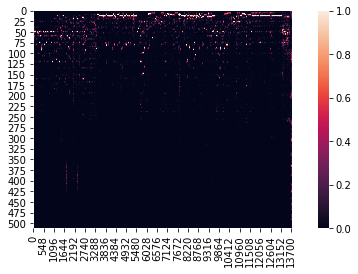

In [68]:
sns.heatmap(spec_minmax)

<AxesSubplot:>

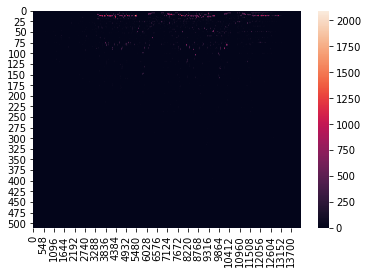

In [69]:
sns.heatmap(spec_raw)

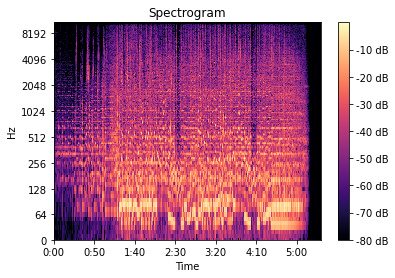

In [75]:
import librosa.display
spec = np.abs(librosa.stft(wav, hop_length=frame_duration))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

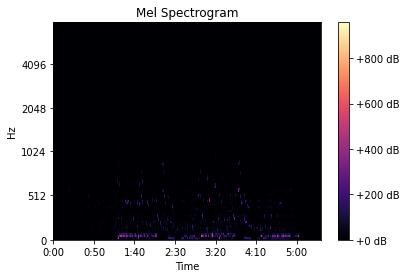

In [98]:
mel_spect = librosa.feature.melspectrogram(y=wav, sr=sr, hop_length=frame_duration)
#mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [87]:
mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

<AxesSubplot:>

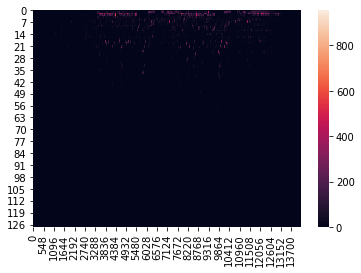

In [85]:
sns.heatmap(mel_spect)

<AxesSubplot:>

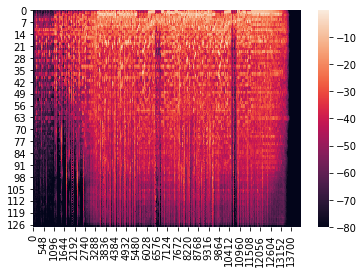

In [88]:
sns.heatmap(mel_spect_db)

[0.00676263 0.00611399 0.004983   0.00477263 0.00473985 0.00532796
 0.00834086 0.01154174 0.01157361 0.0099636 ]


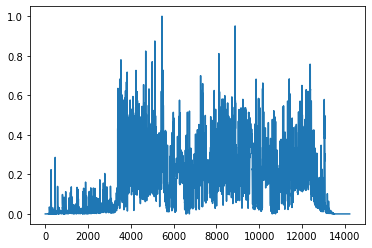

In [107]:
mel_spect = librosa.feature.melspectrogram(y=wav, sr=sr, hop_length=frame_duration, n_mels=512)
spec_max = np.amax(mel_spect, axis=0)

# Normalize all values between 0 and 1
spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)
print(spec_norm[1000:1010])
plt.plot(spec_norm)

In [136]:
def minmax(signal):
    return (signal - signal.min()) / (signal.max() - signal.min())

In [6]:
mel_spect = librosa.feature.melspectrogram(y=wav, sr=sr, hop_length=frame_duration, n_mels=512)
#mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

#spec_max = np.amax(mel_spect, axis=0)
# Normalize all values between 0 and 1
#spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)
#spec_norm = (mel_spect - mel_spect.min()) / (mel_spect.max() - mel_spect.min())
#spec_norm = spec_norm[0]

In [108]:
# get spectrogram
mel_spect = librosa.feature.melspectrogram(y=wav, sr=sr, hop_length=frame_duration, n_mels=512)
# use only the centrail main bands that include 90% quantile
threshold = 0.05  # smaller == more bands included
mean_per_band = mel_spect.mean(axis=1)
mean_per_band /= mean_per_band.sum()
upper_mask = np.cumsum(mean_per_band) < (1 - threshold)
lower_mask = np.cumsum(mean_per_band) > threshold
mask = upper_mask & lower_mask
main_spectrogram = mel_spect[mask]
#print(main_spectrogram.shape)
# find out how to split main spectrogram into 18 roughly equally-sized partitions
rnge = np.arange(len(main_spectrogram))
split_idcs = np.array_split(rnge, 18)
split_idcs
# apply found idcs
sub_spectros = [main_spectrogram[idcs] for idcs in split_idcs]
# get spectral norms for each
sub_spec_norms = np.array([spec.mean(axis=0) for spec in sub_spectros])
print(sub_spec_norms.shape)

def minmax(array, axis):
    return (array - array.min(axis, keepdims=True)) / (array.max(axis, keepdims=True) - array.min(axis, keepdims=True))

sub_minmax = minmax(sub_spec_norms, axis=1)

(18, 14232)


<AxesSubplot:>

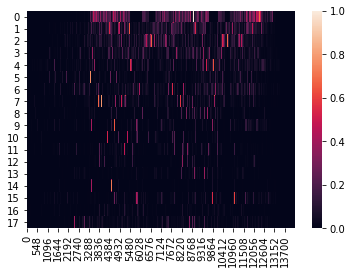

In [109]:
sns.heatmap(sub_minmax)

<AxesSubplot:>

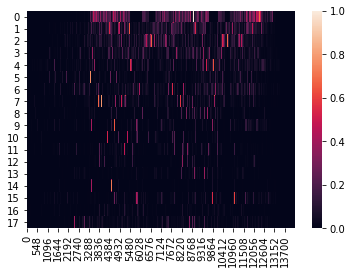

In [104]:
sns.heatmap(sub_minmax)

In [89]:
chromagram = librosa.feature.chroma_cqt(y=wav, sr=sr, C=None, hop_length=frame_duration, 
                           fmin=None, threshold=0.0, tuning=None, 
                           n_chroma=18, n_octaves=7, window=None, bins_per_octave=36, 
                           cqt_mode='full')
chromagram.shape

(18, 14232)

<AxesSubplot:>

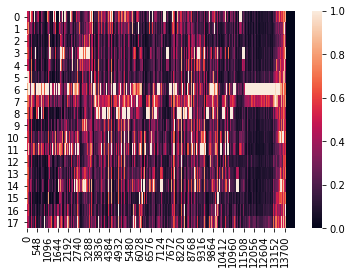

In [87]:
sns.heatmap(chromagram)

(18, 14232)


<AxesSubplot:>

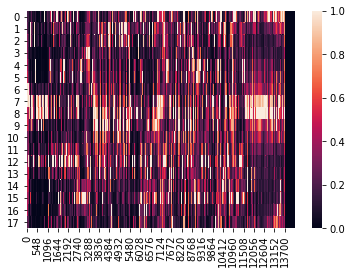

In [101]:
chromagram = librosa.feature.chroma_stft(y=wav, sr=sr, hop_length=frame_duration, 
                           tuning=None, 
                           n_chroma=18, 
                           )
print(chromagram.shape)
sns.heatmap(chromagram)

In [185]:
spec_norm[2].mean()

17.288738

In [181]:
spec_norm[100:200].mean()

0.49101642

In [182]:
spec_norm[200:300].mean()

0.059386197

In [174]:
spec_norm[0].mean()

3.6967535

In [178]:
spec_norm[1].mean()

0.39573067

In [177]:
spec_norm[2].mean()

0.076430835

In [28]:
spec_norm[40:60]

array([0.0000000e+00, 0.0000000e+00, 1.2233763e-13, 1.8017630e-10,
       2.5328819e-09, 1.0850322e-08, 3.5782989e-08, 9.0231836e-08,
       2.3094402e-07, 3.9546123e-07, 6.6277801e-07, 9.9323756e-07,
       1.8557599e-06, 2.4697854e-06, 3.0068879e-06, 3.7464476e-06,
       4.9514488e-06, 5.5010037e-06, 6.9054186e-06, 6.6059383e-06],
      dtype=float32)

In [4]:
# def get_spec_norm(wav, sr, n_mels, hop_length):
from lucidsonicdreams.helper_functions import get_spec_norm
spec_norm = get_spec_norm(wav, sr, 512, frame_duration)

In [6]:
spec_norm.shape

(14232,)

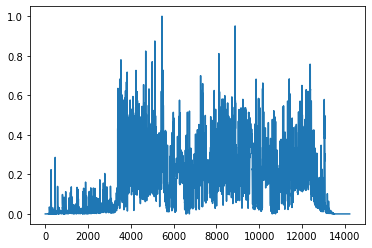

In [5]:
plt.plot(spec_norm)

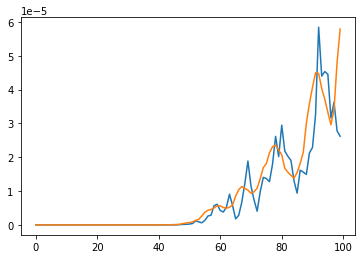

In [55]:
smooth_range = 5
smooth_spec = np.stack([np.mean(spec_norm[i: i + smooth_range], axis=0) for i in range(len(spec_norm - smooth_range))])
plt.plot(spec_norm[:100])
plt.plot(smooth_spec[:100])

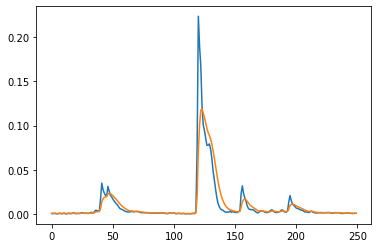

In [62]:
ema_val = 0.75
ema_spec = []
val = spec_norm[0]
for amp in spec_norm:
    val = amp * (1 - ema_val) + ema_val * val
    ema_spec.append(val)
#plt.plot(spec_norm[50:60])
#plt.plot(ema_spec[50:60])
plt.plot(spec_norm[150:400])
plt.plot(ema_spec[150:400])

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
a = torch.arange(0, 1000) / 1000

In [36]:
def minmax(a):
    return (a - a.min()) / (a.max() - a.min())

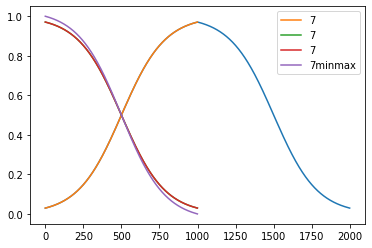

In [37]:
#plt.plot(a)
#plt.plot(torch.sigmoid((a - 0.5) * 6), label="sig6")
streak = torch.cat([torch.sigmoid((a - 0.5) * 7), 1 - torch.sigmoid((a - 0.5) * 7)])
plt.plot(streak)
plt.plot(torch.sigmoid((a - 0.5) * 7), label="7")
plt.plot(1 - torch.sigmoid((a - 0.5) * 7), label="7")
plt.plot(1 - torch.sigmoid((a - 0.5) * 7), label="7")
plt.plot(minmax(1 - torch.sigmoid((a - 0.5) * 7)), label="7minmax")

#plt.plot(torch.sigmoid((a - 0.5) * 8), label="sig8")
#plt.plot(torch.sigmoid((a - 0.5) * 10), label="sig10")
plt.legend()

In [12]:
torch.sigmoid((a - 0.5) * 6).max()

tensor(0.9498)

In [2]:
# should be (50, 18, 512) if opt_all_layers 
    
    # create noise vectors!! 
    # clmr preds shape is (len_song, 50)

In [2]:
latents = torch.rand(50, 18, 512)

In [3]:
preds = torch.rand(5000, 50)

In [4]:
mult = torch.stack([(pred.view(50, 1, 1) * latents).mean(dim=0) for pred in preds])
#agg = mult.mean(dim=1).shape

In [6]:
mult.unsqueeze(1).shape

torch.Size([5000, 1, 18, 512])

torch.Size([5000, 18, 512])

In [39]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
def inv_sig(out):
    return -torch.log((1 / out) - 1)

In [163]:
henne = torch.load("clmr_preds_henne_sigmoid.pt")
gnossi = torch.load("clmr_preds_gnossi_sigmoid.pt")
tags = np.array(torch.load("clmr_tags.pt"))

In [164]:
henne_mean = henne.mean(dim=0)
henne_std = henne.std(dim=0)
gnossi_mean = gnossi.mean(dim=0) 
gnossi_std = gnossi.std(dim=0) 

In [165]:
df = pd.DataFrame({"henne_mean": henne_mean, "henne_std": henne_std, "gnossi_mean": gnossi_mean, "gnossi_std": gnossi_std, "tag": tags})
df["diff_mean"] = df["henne_mean"] - df["gnossi_mean"]
df["diff_std"] = df["henne_std"] - df["gnossi_std"]

In [29]:
#df.sort_values("henne_mean")

In [169]:
smooth_frac = 0.005
smooth_range = int(len(henne) * smooth_frac)
smooth_henne = torch.stack([torch.mean(henne[i: i + smooth_range], dim=0) for i in range(len(henne - smooth_range))])
smooth_range = int(len(gnossi) * smooth_frac)
smooth_gnossi = torch.stack([torch.mean(gnossi[i: i + smooth_range], dim=0) for i in range(len(gnossi - smooth_range))])

In [199]:
smooth_range = 173
smoothed = torch.stack([torch.mean(henne[max(i - smooth_range, 0): i + 1], dim=0) for i in range(len(henne))])


In [200]:
smoothed[0]

tensor([2.5184e-02, 7.0936e-01, 9.8544e-02, 1.3120e-08, 2.2700e-01, 3.9356e-07,
        4.6362e-07, 1.8218e-06, 2.0170e-03, 2.1140e-02, 1.3879e-04, 5.1669e-08,
        1.9906e-01, 1.9367e-04, 1.5387e-06, 1.2982e-04, 2.0861e-05, 1.5294e-03,
        2.8864e-05, 7.4027e-05, 8.5723e-05, 1.1498e-02, 1.3442e-01, 1.5399e-05,
        6.0474e-02, 2.3253e-02, 6.6618e-05, 3.5417e-06, 9.6698e-03, 1.0963e-06,
        5.4208e-02, 2.2287e-05, 6.1645e-03, 6.3059e-06, 6.0752e-02, 1.4497e-04,
        2.3549e-05, 4.3182e-05, 2.5697e-08, 2.6610e-06, 2.2733e-05, 1.1660e-09,
        9.8189e-03, 4.7692e-03, 3.7581e-03, 2.6185e-06, 1.9022e-05, 2.2694e-08,
        2.3472e-05, 5.2797e-05])

In [201]:
henne[0]

tensor([2.5184e-02, 7.0936e-01, 9.8544e-02, 1.3120e-08, 2.2700e-01, 3.9356e-07,
        4.6362e-07, 1.8218e-06, 2.0170e-03, 2.1140e-02, 1.3879e-04, 5.1669e-08,
        1.9906e-01, 1.9367e-04, 1.5387e-06, 1.2982e-04, 2.0861e-05, 1.5294e-03,
        2.8864e-05, 7.4027e-05, 8.5723e-05, 1.1498e-02, 1.3442e-01, 1.5399e-05,
        6.0474e-02, 2.3253e-02, 6.6618e-05, 3.5417e-06, 9.6698e-03, 1.0963e-06,
        5.4208e-02, 2.2287e-05, 6.1645e-03, 6.3059e-06, 6.0752e-02, 1.4497e-04,
        2.3549e-05, 4.3182e-05, 2.5697e-08, 2.6610e-06, 2.2733e-05, 1.1660e-09,
        9.8189e-03, 4.7692e-03, 3.7581e-03, 2.6185e-06, 1.9022e-05, 2.2694e-08,
        2.3472e-05, 5.2797e-05])

In [208]:
print([(max(i - smooth_range, 0), i + 1)for i in range(200)])

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0, 100), (0, 101), (0, 102), (0, 103), (0, 104), (0, 105), (0, 106), (0, 107), (0, 108), (0, 109), (0, 110), (0, 111

In [202]:
len(smoothed)

34627

In [203]:
len(smooth_henne)

34627

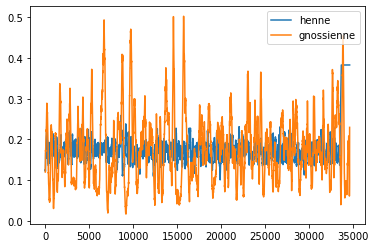

In [204]:
tag = "guitar"
mask = tags == tag
extract = smooth_henne[:, mask].squeeze()
p = plt.plot(extract, label="henne")
#p = plt.ylim(0, 1)

extract = smooth_gnossi[:, mask].squeeze()
x_coords = np.arange(len(gnossi)) * (len(henne) / len(gnossi))
p = plt.plot(x_coords, extract, label="gnossienne")
plt.legend()
#p = plt.ylim(0, 1)

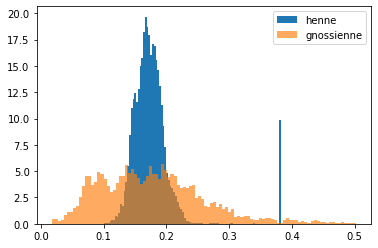

In [319]:
extract = smooth_henne[:, mask].squeeze().numpy()
p = plt.hist(extract, label="henne", bins=100, density=True, alpha=1.0)

extract = smooth_gnossi[:, mask].squeeze().numpy()
p = plt.hist(extract, label="gnossienne", bins=100, density=True, alpha=0.66)
plt.legend()

In [320]:
gnossi[100].mul(100).int()

tensor([ 8,  2,  0, 36,  1,  3,  9,  6, 60,  4,  0,  2,  0,  8,  1, 17,  1,  0,
         2,  4,  9,  2,  3,  7,  0,  0, 11,  2,  3,  2,  0,  0,  0,  1,  0,  0,
         4,  0,  5,  1,  8,  0,  1,  0,  1,  1,  0,  1,  3,  0],
       dtype=torch.int32)

In [321]:
tags

array(['guitar', 'classical', 'slow', 'techno', 'strings', 'drums',
       'electronic', 'rock', 'fast', 'piano', 'ambient', 'beat', 'violin',
       'vocal', 'synth', 'female', 'indian', 'opera', 'male', 'singing',
       'vocals', 'no vocals', 'harpsichord', 'loud', 'quiet', 'flute',
       'woman', 'male vocal', 'no vocal', 'pop', 'soft', 'sitar', 'solo',
       'man', 'classic', 'choir', 'voice', 'new age', 'dance',
       'male voice', 'female vocal', 'beats', 'harp', 'cello', 'no voice',
       'weird', 'country', 'metal', 'female voice', 'choral'],
      dtype='<U12')

In [ ]:
# 1. go to cloned musicnn repo and install with "python3 -m pip install ."

# 2. find out which directory is used
#python3
#import musicnn
#musicnn.__path__

# 3. copy big model in the package diretory manually
# cp -r MSD_musicnn_big {__path__ from above}
# for example: cp -r MSD_musicnn_big/ /home/anton/.local/lib/python3.8/site-packages/musicnn

In [1]:
import musicnn

In [2]:
songs = ["songs/gnossi_1.mp3", "songs/henne_song.mp3"]

In [1]:
from musicnn.extractor import extractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
in_length = 3 # seconds  by default, the model takes inputs of 3 seconds with no overlap

plt.rcParams["figure.figsize"] = (10,8) # set size of the figures
fontsize = 12 # set figures font size

def show_taggram(taggram, tags, name="", save=False):
    fig, ax = plt.subplots()

    # title
    ax.title.set_text('Taggram')
    ax.title.set_fontsize(fontsize)

    # x-axis title
    ax.set_xlabel('(seconds)', fontsize=fontsize)

    # y-axis
    y_pos = np.arange(len(tags))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tags, fontsize=fontsize-1)

    # x-axis
    x_pos = np.arange(taggram.shape[0])
    x_label = np.arange(in_length/2, in_length*taggram.shape[0], 3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label, fontsize=fontsize)

    # depict taggram
    ax.imshow(taggram.T, interpolation=None, aspect="auto")
    plt.show()
    if save:
        plt.savefig(f"taggram_{name}.png")



In [9]:
taggram, tags = extractor(songs[0], model='MSD_musicnn', extract_features=False, input_overlap=None)
# models = 'MTT_musicnn', 'MTT_vgg', 'MSD_musicnn', 'MSD_musicnn_big' or 'MSD_vgg'.

/home/anton/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/anton/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/anton/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprec

Computing spectrogram (w/ librosa) and tags (w/ tensorflow).. 

/home/anton/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


done!


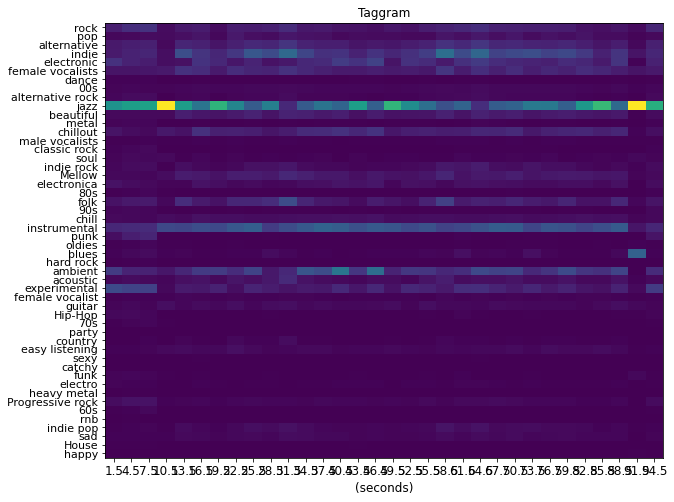

In [10]:
#MSD small
show_taggram(taggram, tags)

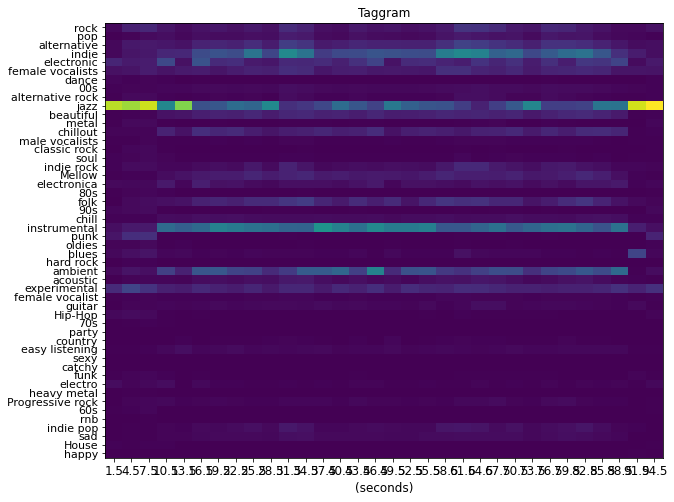

In [8]:
# MSD big None overlap
show_taggram(taggram, tags)

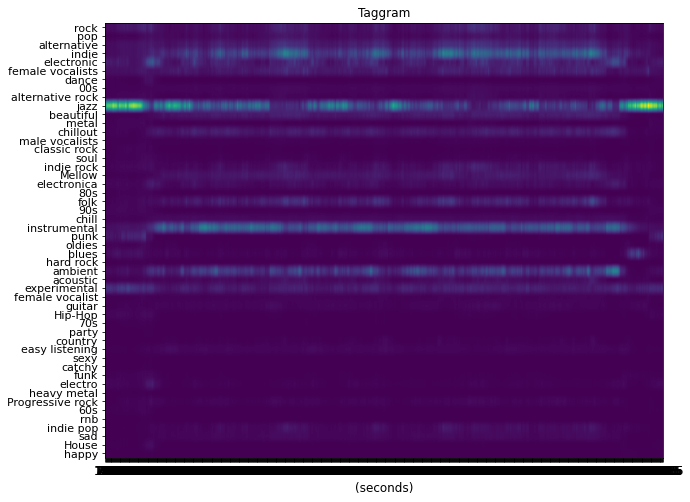

In [6]:
# MSD big 0.1 overlap
show_taggram(taggram, tags)

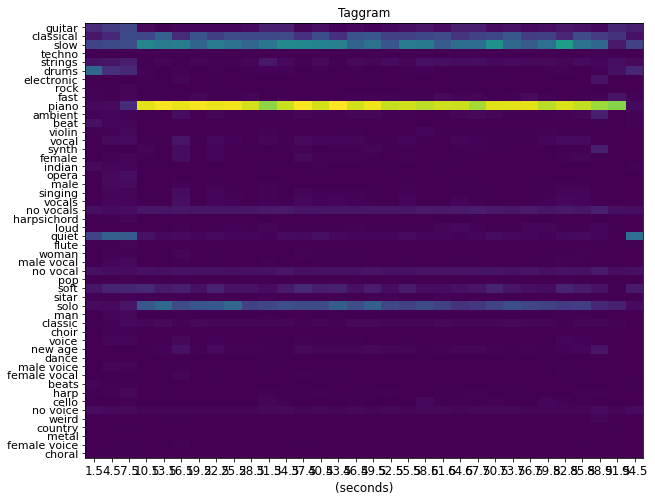

In [8]:
show_taggram(taggram, tags)

In [10]:
taggram.shape

(32, 50)

In [12]:
taggram.shape

(33, 50)

In [14]:
taggram.shape

(97, 50)

In [16]:
taggram.shape

(1177, 50)

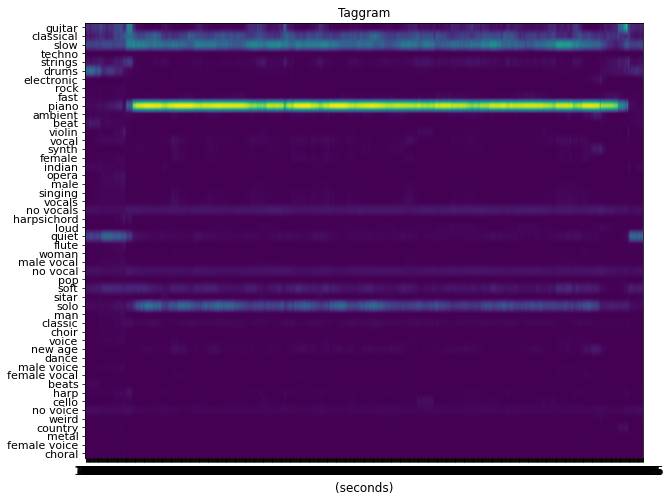

In [17]:
show_taggram(taggram, tags)

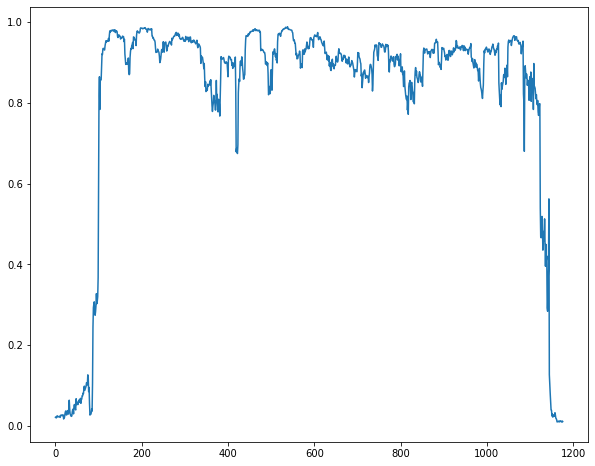

In [28]:
plt.plot(taggram[:, 9])